# Attention Is All You Need

In [13]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [14]:
import torch
from torch import nn

## Model Design

In [15]:
# # We simulate data like this:
# BATCH_SIZE = 2
# SEQ_LENGTH = 10
# EMBEDDING_DIM = 64
# MODEL_DIM = 64
# # Fake input
# dummy_input = torch.rand(BATCH_SIZE, SEQ_LENGTH, EMBEDDING_DIM)

# s1, s2 = dummy_input[0, :], dummy_input[1, :]
# s1 = s1.unsqueeze(0)
# s2 = s2.unsqueeze(0)


# dummy_raw = torch.randint(0, 100, (BATCH_SIZE, SEQ_LENGTH))

In [16]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'

DEVICE

'cuda'

In [17]:
import math

class PositionalEncoder(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.shape[1], :]

In [18]:
from torch import nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, model_dim, dropout=None):
        super().__init__()

        self.w_key = nn.Linear(model_dim, model_dim, bias=False)
        self.w_query = nn.Linear(model_dim, model_dim, bias=False)
        self.w_value = nn.Linear(model_dim, model_dim, bias=False)
        self.scale = model_dim ** 0.5
        self.dropout = dropout

    def forward(self, batch, encoder_output=None, mask=None):
        '''
        if encoder output is None, it calculates self-attention; otherwise, cross-attention
        '''
        key = self.w_key(encoder_output) if (encoder_output is not None) else self.w_key(batch)
        query = self.w_query(batch)
        value = self.w_value(encoder_output) if (encoder_output is not None) else self.w_value(batch)

        attention_scores = query @ key.transpose(-2, -1)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask.bool(), float('-inf'))
        # [batch_size, seq_length, seq_length]

        attention_scores = F.softmax(attention_scores / self.scale, dim=-1)

        if self.dropout is not None:
            attention_scores = self.dropout(attention_scores)

        return attention_scores @ value

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, model_dim, dropout):
        super().__init__()
        self.dropout = dropout
        self.attention = Attention(model_dim, self.dropout)
        self.layer_norm_attn = nn.LayerNorm(normalized_shape=model_dim)
        self.layer_norm_ffn = nn.LayerNorm(normalized_shape=model_dim)
        self.ffn = nn.Sequential(
            nn.Linear(model_dim, model_dim*4),
            nn.ReLU(),
            nn.Linear(model_dim*4, model_dim),
        )

    def add_and_norm(self, input_embedding, attention_vector, norm):
        return norm(
            input_embedding + self.dropout(attention_vector)
        )

    def forward(self, x, mask=None):
        attention_vector = self.attention(x, mask=mask)
        x = self.add_and_norm(x, attention_vector, norm=self.layer_norm_attn)
        ffn_output = self.ffn(x)
        x = self.add_and_norm(x, ffn_output, norm=self.layer_norm_ffn)

        return x

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, model_dim, dropout=None):
        super().__init__()
        self.dropout = dropout
        self.self_attention = Attention(model_dim, self.dropout)
        self.cross_attention = Attention(model_dim, self.dropout)
        self.layer_norm_self_attn = nn.LayerNorm(normalized_shape=model_dim)
        self.layer_norm_cross_attn = nn.LayerNorm(normalized_shape=model_dim)
        self.layer_norm_fnn = nn.LayerNorm(normalized_shape=model_dim)
        self.fnn = nn.Sequential(
            nn.Linear(model_dim, model_dim * 4),
            nn.ReLU(),
            nn.Linear(model_dim * 4, model_dim)
        )

    def add_and_norm(self, input_embedding, attention_vector, norm):
        return norm(
            input_embedding + self.dropout(attention_vector)
        )

    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        # calculating the self-attention
        seq_len = x.shape[-2]
        triangle_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1).to(device=x.device)
        self_attention_vector = self.self_attention(x, mask=(triangle_mask | tgt_mask.to(x.device)))
        x = self.add_and_norm(x, self_attention_vector, norm=self.layer_norm_self_attn)

        # calculating the cross-attention
        seq_len = x.shape[1]
        cross_attention_vector = self.cross_attention(x, encoder_output=encoder_output, mask=src_mask)
        x = self.add_and_norm(x, cross_attention_vector, norm=self.layer_norm_cross_attn)

        # FNN layer
        fnn_output = self.fnn(x)
        x = self.add_and_norm(x, fnn_output, norm=self.layer_norm_fnn)

        return x

In [21]:
class Transformer(nn.Module):
    def __init__(self, model_dim, num_layers, src_vocab_size, tgt_vocab_size, padding_idx, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        self.padding_idx = padding_idx

        self.encoder_embedding = nn.Embedding(
            num_embeddings=src_vocab_size,
            embedding_dim=model_dim,
            padding_idx=padding_idx
        )

        self.decoder_embedding = nn.Embedding(
            num_embeddings=tgt_vocab_size,
            embedding_dim=model_dim,
            padding_idx=padding_idx
        )

        self.dropout = nn.Dropout(p=dropout)

        # NOTE: In the original paper, they used one embedding for both the encoder and decoder, to reduce the model's weights and more optimization
        # in this implementation, we used 2 different embeddings for simplicity

        self.positional_encoder = PositionalEncoder(model_dim, max_len=5000)

        self.encoder_layers = nn.ModuleList(EncoderLayer(model_dim, self.dropout) for _ in range(num_layers))
        self.decoder_layers = nn.ModuleList(DecoderLayer(model_dim, self.dropout) for _ in range(num_layers))

        self.fc_out = nn.Linear(model_dim, tgt_vocab_size)
        # NOTE: In the original paper, they used the embedding for the output too, since they realized these are just transpose of each other
        # Embedding: Maps "Word ID" -> "Vector"
        # Final Layer: Maps "Vector" -> "Word Probability"

    def forward(self, src, tgt):
        # --- Embedding --- #
        src_embedding = self.encoder_embedding(src) * math.sqrt(self.model_dim)
        tgt_embedding = self.decoder_embedding(tgt) * math.sqrt(self.model_dim)
        # [batch_size, seq_len, model_dim]

        # --- Positional Encoding --- #
        src_embedding = self.positional_encoder(src_embedding)
        tgt_embedding = self.positional_encoder(tgt_embedding)
        # [batch_size, seq_len, model_dim]

        # Dropout
        src_embedding = self.dropout(src_embedding)
        tgt_embedding = self.dropout(tgt_embedding)

        # --- Encoder ---
        src_mask = (src == self.padding_idx) # padding mask
        src_mask = src_mask.unsqueeze(1) # ! for multi-head attention, we should unsqueeze(2) in addition to what we have
        # [batch_size, 1, seq_len]
        for encoder in self.encoder_layers:
            src_embedding = encoder(src_embedding, mask=src_mask)
        encoder_outputs = src_embedding # just a rename for better readability

        # --- Decoder ---
        tgt_mask = (tgt == self.padding_idx) # padding mask
        tgt_mask = tgt_mask.unsqueeze(1)
        for decoder in self.decoder_layers:
            tgt_embedding = decoder(tgt_embedding, encoder_outputs, tgt_mask=tgt_mask, src_mask=src_mask)
        decoder_outputs = tgt_embedding

        return self.fc_out(decoder_outputs)

## Loading Data

- Download the dataset
- Split to train/test/validation
- Tokenizer/Cleaning Functions
- Create Vocabs
- WordToIndex / IndexToWord Functions
- Dataset Class
- DataLoader & collate_function

In [ ]:
# uv pip install datasets spacy
# uv run spacy download en_core_web_sm
# uv run spacy download de_core_news_sm

# # for colab
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
import torch
import spacy
from datasets import load_dataset
from collections import Counter

# We use the 'bentrevett/multi30k' mirror as the official one is often down
print("Downloading Dataset...")
dataset = load_dataset("bentrevett/multi30k")

train_data = dataset['train']
val_data = dataset['validation']
test_data  = dataset['test']

print(f"Train size: {len(train_data)}")
print(f"Example: {train_data[0]}")
# Output: {'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

# 2. Tokenizers (Spacy)
spacy_en = spacy.load("en_core_web_sm")
spacy_de = spacy.load("de_core_news_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

# 3. Build Vocabulary
def build_vocab(sentences, tokenizer, min_freq=2):
    counter = Counter()
    for s in sentences:
        counter.update(tokenizer(s))

    # Start with special tokens
    vocab = {'[PAD]': 0, '[SOS]': 1, '[EOS]': 2, '[UNK]': 3}
    idx = 4

    # filtering the vocab based on a minimum threshold
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1

    # to make this deterministic, we sort by word
    vocab = dict(sorted(vocab.items()))

    return vocab

print("Building Vocabularies... (this takes a moment)")
src_vocab = build_vocab([x['en'] for x in train_data], tokenize_en)
tgt_vocab = build_vocab([x['de'] for x in train_data], tokenize_de)

print(f"Source (EN) Vocab Size: {len(src_vocab)}")
print(f"Target (DE) Vocab Size: {len(tgt_vocab)}")

In [24]:
reversed_src_vocab = {k: w for w, k in src_vocab.items()}
reversed_tgt_vocab = {k: w for w, k in tgt_vocab.items()}

In [25]:
def word2idx(tokens, vocab):
    return [vocab.get(w, vocab['[UNK]']) for w in tokens]

def idx2word(idx_tokens: torch.Tensor, reversed_vocab):
    idx_tokens = idx_tokens.tolist()
    return " ".join([reversed_vocab.get(w) for w in idx_tokens])

In [26]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class Multi30kDataset(Dataset):
    def __init__(self, dataset, src_vocab, tgt_vocab):
        super().__init__()
        self.dataset = dataset
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __getitem__(self, index):
        src_tensor = torch.tensor(
            [self.src_vocab['[SOS]']] + word2idx(tokenize_en(self.dataset[index]['en']), self.src_vocab) + [self.src_vocab['[EOS]']]
        )
        tgt_tensor = torch.tensor(
            [self.src_vocab['[SOS]']] + word2idx(tokenize_de(self.dataset[index]['de']), self.tgt_vocab) + [self.src_vocab['[EOS]']]
        )
        return src_tensor, tgt_tensor

    def __len__(self):
        return len(self.dataset)

def collate_function(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_batch = pad_sequence(src_batch, padding_value=src_vocab['[PAD]'], batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=tgt_vocab['[PAD]'], batch_first=True)
    return src_batch, tgt_batch

In [27]:
BATCH_SIZE = 512

train_dataset = Multi30kDataset(train_data, src_vocab, tgt_vocab)
val_dataset = Multi30kDataset(val_data, src_vocab, tgt_vocab)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_function,
    shuffle=True,
    num_workers=2,            # PARALLEL LOADING (Try 2 or 4 in Colab)
    pin_memory=True           # FASTER TRANSFER (CPU -> GPU)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_function,
    shuffle=True,
    num_workers=2,            # PARALLEL LOADING (Try 2 or 4 in Colab)
    pin_memory=True           # FASTER TRANSFER (CPU -> GPU)
)

## Inspect Model Design

In [ ]:
# import StepLR
from torch.optim.lr_scheduler import StepLR

EPOCH = 15
NUM_LAYERS = 5
LEARNING_RATE = 0.001
PADDING_IDX = src_vocab['[PAD]'] # ! the src and tgt vocab must have the same padding ( could be fixed in the Transformer class)
MODEL_DIM = 512

transformer = Transformer(
    model_dim=MODEL_DIM,
    num_layers=NUM_LAYERS,
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    padding_idx=PADDING_IDX,
)

criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, label_smoothing=0.1)
optimizer = torch.optim.Adam(params=transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=10e-9)
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.70)

In [ ]:
from torchinfo import summary

src_sample_batch, tgt_sample_batch = next(iter(train_dataloader))
summary(transformer, input_data=(src_sample_batch, tgt_sample_batch))

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [128, 30, 7853]           --
├─Embedding: 1-1                         [128, 29, 512]            3,017,216
├─Embedding: 1-2                         [128, 30, 512]            4,020,736
├─PositionalEncoder: 1-3                 [128, 29, 512]            --
├─PositionalEncoder: 1-4                 [128, 30, 512]            --
├─ModuleList: 1-5                        --                        --
│    └─EncoderLayer: 2-1                 [128, 29, 512]            --
│    │    └─Attention: 3-1               [128, 29, 512]            786,432
│    │    └─LayerNorm: 3-2               [128, 29, 512]            1,024
│    │    └─Sequential: 3-3              [128, 29, 512]            2,099,712
│    │    └─LayerNorm: 3-4               [128, 29, 512]            1,024
│    └─EncoderLayer: 2-2                 [128, 29, 512]            --
│    │    └─Attention: 3-5               [128, 29, 51

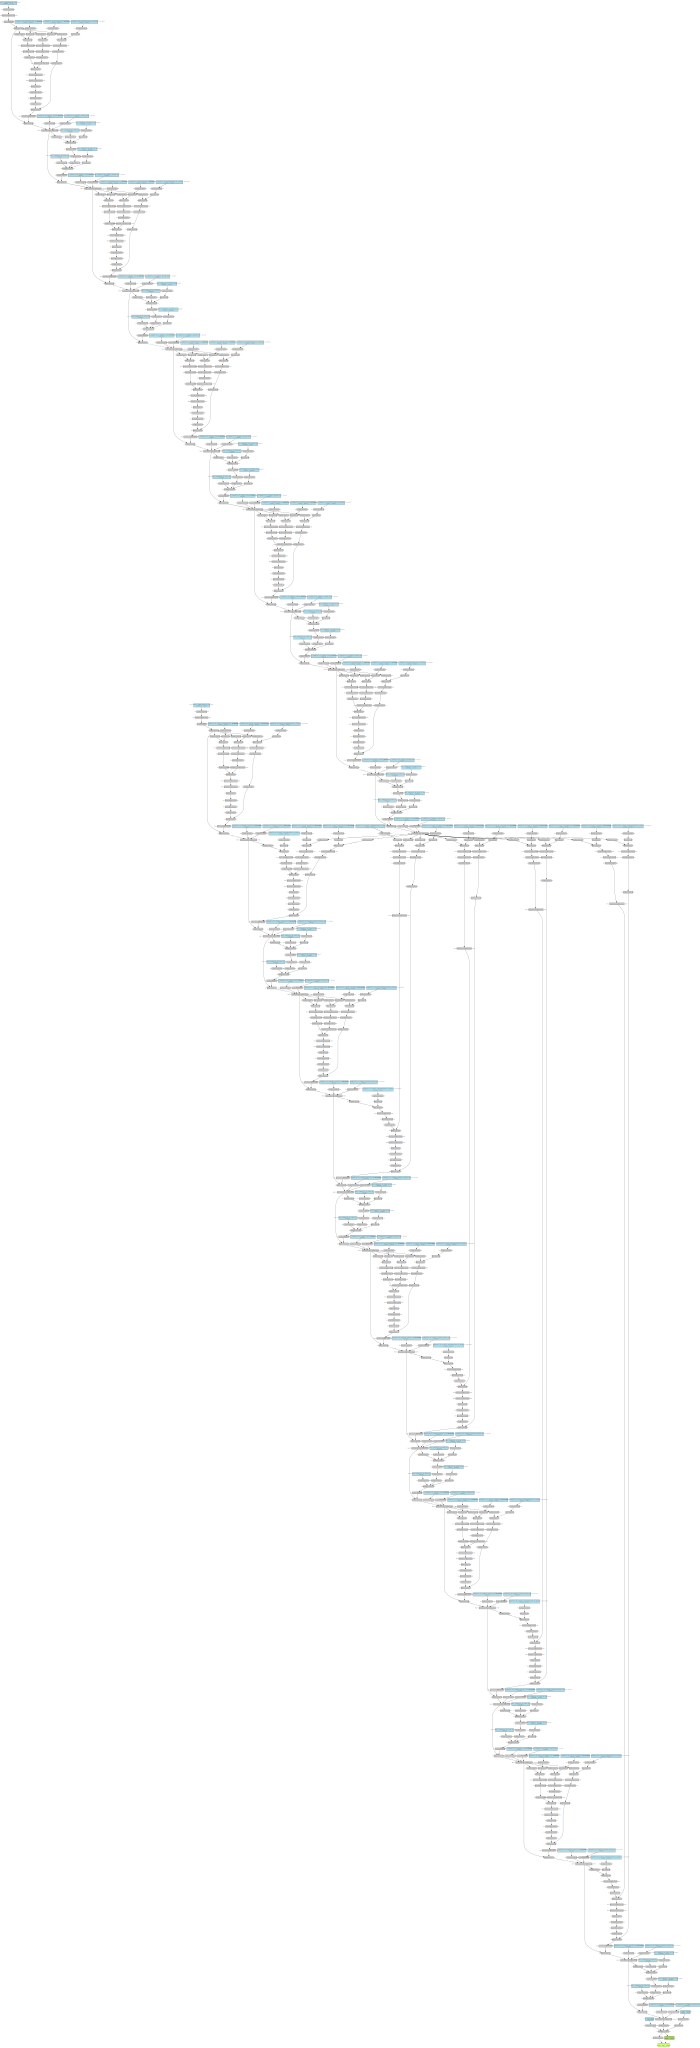

In [ ]:
from torchviz import make_dot

outputs = transformer(*next(iter(train_dataloader)))
make_dot(outputs, params=dict(transformer.named_parameters()))

In [ ]:
# import StepLR
from torch.optim.lr_scheduler import StepLR

EPOCH = 15
NUM_LAYERS = 5
LEARNING_RATE = 0.001
PADDING_IDX = src_vocab['[PAD]'] # ! the src and tgt vocab must have the same padding ( could be fixed in the Transformer class)
MODEL_DIM = 512

transformer = Transformer(
    model_dim=MODEL_DIM,
    num_layers=NUM_LAYERS,
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    padding_idx=PADDING_IDX,
)

criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, label_smoothing=0.1)
optimizer = torch.optim.Adam(params=transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=10e-9)
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.70)

# for epoch in range(EPOCH):
#     for src, tgt in train_dataloader:
#         src, tgt = src.to(DEVICE), tgt.to(DEVICE)
#         logits = transformer(src, tgt)
#         loss = criterion()

## Train

In [36]:
def train_batch(model, src, tgt, optimizer, criterion, clip):
    # Shift Targets
    tgt_input = tgt[:, :-1] # Remove <EOS> at the end
    tgt_output = tgt[:, 1:] # Remove <SOS> at the start

    optimizer.zero_grad()
    logits = model(src, tgt_input)
    loss = criterion(logits.permute(0, 2, 1), tgt_output)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip) # Clip Gradients
    optimizer.step()

    return loss.item()


def evaluate_batch(model, src, tgt, criterion):
    # Shift Targets
    tgt_input = tgt[:, :-1] # Remove <EOS> at the end
    tgt_output = tgt[:, 1:] # Remove <SOS> at the start

    with torch.inference_mode():
        logits = model(src, tgt_input)
        loss = criterion(logits.permute(0, 2, 1), tgt_output)

    return loss.item()

In [40]:
from torch.optim.lr_scheduler import StepLR
import gc

EPOCH = 25
NUM_LAYERS = 3
LEARNING_RATE = 0.0005
PADDING_IDX = src_vocab['[PAD]'] # ! the src and tgt vocab must have the same padding index ( could be fixed in the Transformer class)
MODEL_DIM = 256
GRAD_CLIP_VALUE = 1
DROPOUT = 0.25

def run_training():
    transformer = Transformer(
        model_dim=MODEL_DIM,
        num_layers=NUM_LAYERS,
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        padding_idx=PADDING_IDX,
        dropout=DROPOUT
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=PADDING_IDX, label_smoothing=0.1) # NOTE -> Label smoothing is important to add here, it makes our loss Super-CrossEntropy !
    optimizer = torch.optim.Adam(params=transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)
    scheduler = StepLR(optimizer=optimizer, step_size=7, gamma=0.8)

    train_loss_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    try:
        for epoch in range(EPOCH):
            # --- Train --- #
            transformer.train()
            total_train_loss = 0
            for src, tgt in train_dataloader:
                src, tgt = src.to(DEVICE), tgt.to(DEVICE)
                total_train_loss += train_batch(transformer, src, tgt, optimizer, criterion, GRAD_CLIP_VALUE)

            # --- Validation --- #
            total_val_loss = 0
            transformer.eval()
            for src, tgt in val_dataloader:
                src, tgt = src.to(DEVICE), tgt.to(DEVICE)
                total_val_loss += evaluate_batch(transformer, src, tgt, criterion)

            train_loss_list.append(total_train_loss / len(train_dataloader))
            val_loss_list.append(total_val_loss / len(val_dataloader))

            # --- Log Output --- #
            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss_list[-1]:.4f} | Train PPL: {math.exp(train_loss_list[-1]):.4f}')
            print(f'\t Val. Loss: {val_loss_list[-1]:.4f} |  Val. PPL: {math.exp(val_loss_list[-1]):.4f}')
            print(f'\t Learning Rate: {scheduler.get_last_lr()}')

            scheduler.step()

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            torch.save(transformer.state_dict(), 'best_model.pth')
            # print(f"    -> Saved best model (Loss: {best_val_loss:.4f})")

    except KeyboardInterrupt:
        print("Training interrupted by user.")

    except Exception as e:
        print(f"Training crashed with error: {e}")

    finally:
        print("Cleaning up GPU memory...")
        del optimizer
        del scheduler
        gc.collect() # <--- Force Python garbage collection
        torch.cuda.empty_cache() # <--- Clear GPU cache
        torch.cuda.ipc_collect()

    return transformer, train_loss_list, val_loss_list

In [41]:
transformer, train_loss_list, val_loss_list = run_training()

Epoch: 01
	Train Loss: 5.9975 | Train PPL: 402.4113
	 Val. Loss: 4.9850 |  Val. PPL: 146.2015
	 Learning Rate: [0.0005]
Epoch: 02
	Train Loss: 4.8457 | Train PPL: 127.1903
	 Val. Loss: 4.5003 |  Val. PPL: 90.0440
	 Learning Rate: [0.0005]
Epoch: 03
	Train Loss: 4.4867 | Train PPL: 88.8247
	 Val. Loss: 4.1933 |  Val. PPL: 66.2383
	 Learning Rate: [0.0005]
Epoch: 04
	Train Loss: 4.2413 | Train PPL: 69.5011
	 Val. Loss: 4.0024 |  Val. PPL: 54.7309
	 Learning Rate: [0.0005]
Epoch: 05
	Train Loss: 4.0542 | Train PPL: 57.6390
	 Val. Loss: 3.8466 |  Val. PPL: 46.8320
	 Learning Rate: [0.0005]
Epoch: 06
	Train Loss: 3.9076 | Train PPL: 49.7789
	 Val. Loss: 3.7146 |  Val. PPL: 41.0419
	 Learning Rate: [0.0005]
Epoch: 07
	Train Loss: 3.7819 | Train PPL: 43.9009
	 Val. Loss: 3.6241 |  Val. PPL: 37.4913
	 Learning Rate: [0.0005]
Epoch: 08
	Train Loss: 3.6766 | Train PPL: 39.5117
	 Val. Loss: 3.5365 |  Val. PPL: 34.3457
	 Learning Rate: [0.0004]
Epoch: 09
	Train Loss: 3.5964 | Train PPL: 36.4684
	 

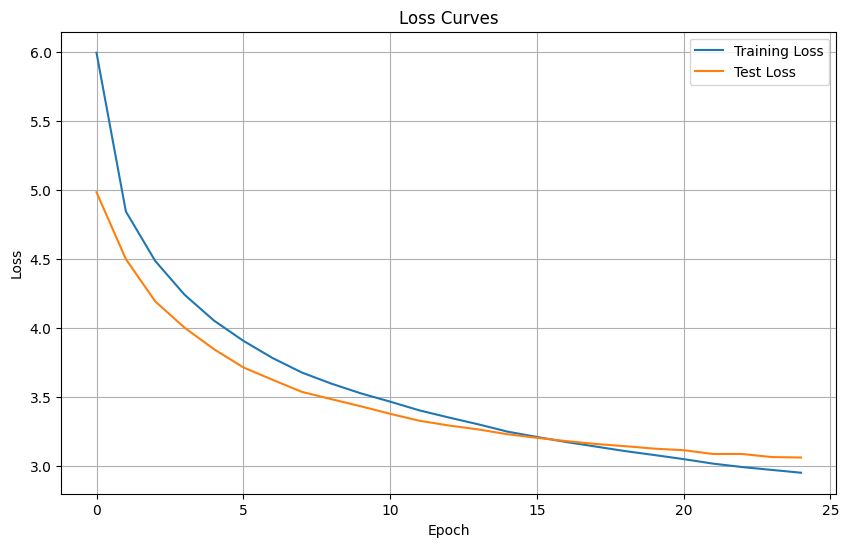

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_curves(train_loss, test_loss):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(train_loss)), y=train_loss, label='Training Loss')
    sns.lineplot(x=range(len(test_loss)), y=test_loss, label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_loss_list, val_loss_list)